episode: 0 score: 20.0


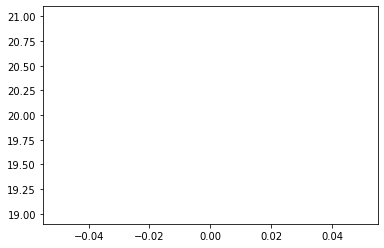

tf.Tensor(-3.835079, shape=(), dtype=float32)
huhu
tf.Tensor(194.68018, shape=(), dtype=float32)
tf.Tensor(-14.4723015, shape=(), dtype=float32)
huhu
tf.Tensor(579.7162, shape=(), dtype=float32)
tf.Tensor(1.1272266, shape=(), dtype=float32)
huhu
tf.Tensor(385.45483, shape=(), dtype=float32)
tf.Tensor(-3.8187256, shape=(), dtype=float32)
huhu
tf.Tensor(192.48332, shape=(), dtype=float32)
tf.Tensor(-4.335938, shape=(), dtype=float32)
huhu
tf.Tensor(573.01953, shape=(), dtype=float32)
tf.Tensor(1.1470141, shape=(), dtype=float32)
huhu
tf.Tensor(190.98961, shape=(), dtype=float32)
tf.Tensor(-3.8236346, shape=(), dtype=float32)
huhu
tf.Tensor(379.43594, shape=(), dtype=float32)
tf.Tensor(0.99587446, shape=(), dtype=float32)
huhu
tf.Tensor(566.3615, shape=(), dtype=float32)
tf.Tensor(-3.7657294, shape=(), dtype=float32)
huhu
tf.Tensor(188.76878, shape=(), dtype=float32)
tf.Tensor(-9.228525, shape=(), dtype=float32)
huhu
tf.Tensor(374.96872, shape=(), dtype=float32)
tf.Tensor(0.0033533233, sh

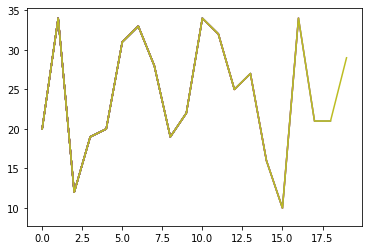

tf.Tensor(-9.120327, shape=(), dtype=float32)
huhu
tf.Tensor(372.09747, shape=(), dtype=float32)
tf.Tensor(1.0673976, shape=(), dtype=float32)
huhu
tf.Tensor(370.63913, shape=(), dtype=float32)
tf.Tensor(1.0568826, shape=(), dtype=float32)
huhu
tf.Tensor(185.13708, shape=(), dtype=float32)
tf.Tensor(-3.6563845, shape=(), dtype=float32)
huhu
tf.Tensor(367.6928, shape=(), dtype=float32)
tf.Tensor(1.0792038, shape=(), dtype=float32)
huhu
tf.Tensor(548.7236, shape=(), dtype=float32)
tf.Tensor(-8.8458, shape=(), dtype=float32)
huhu
tf.Tensor(364.66345, shape=(), dtype=float32)
tf.Tensor(-3.864514, shape=(), dtype=float32)
huhu
tf.Tensor(182.10588, shape=(), dtype=float32)
tf.Tensor(-4.19602, shape=(), dtype=float32)
huhu
tf.Tensor(721.87384, shape=(), dtype=float32)
tf.Tensor(-3.9481473, shape=(), dtype=float32)
huhu
tf.Tensor(180.57994, shape=(), dtype=float32)
tf.Tensor(-9.724561, shape=(), dtype=float32)
huhu
tf.Tensor(537.23206, shape=(), dtype=float32)
tf.Tensor(-4.0894537, shape=(), d

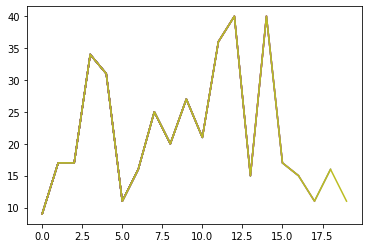

tf.Tensor(-4.19874, shape=(), dtype=float32)
huhu
tf.Tensor(347.215, shape=(), dtype=float32)
tf.Tensor(1.6092076, shape=(), dtype=float32)
huhu
tf.Tensor(345.6131, shape=(), dtype=float32)
tf.Tensor(-4.19721, shape=(), dtype=float32)
huhu
tf.Tensor(343.99722, shape=(), dtype=float32)
tf.Tensor(1.6286992, shape=(), dtype=float32)
huhu
tf.Tensor(171.72229, shape=(), dtype=float32)
tf.Tensor(1.5791553, shape=(), dtype=float32)
huhu
tf.Tensor(340.6544, shape=(), dtype=float32)
tf.Tensor(-9.873316, shape=(), dtype=float32)
huhu
tf.Tensor(507.81433, shape=(), dtype=float32)
tf.Tensor(-4.018466, shape=(), dtype=float32)
huhu
tf.Tensor(337.13702, shape=(), dtype=float32)
tf.Tensor(1.7847662, shape=(), dtype=float32)
huhu
tf.Tensor(168.35841, shape=(), dtype=float32)
tf.Tensor(-3.879582, shape=(), dtype=float32)
huhu
tf.Tensor(500.10507, shape=(), dtype=float32)
tf.Tensor(-10.2694645, shape=(), dtype=float32)
huhu
tf.Tensor(497.3971, shape=(), dtype=float32)
tf.Tensor(-9.767306, shape=(), dtyp

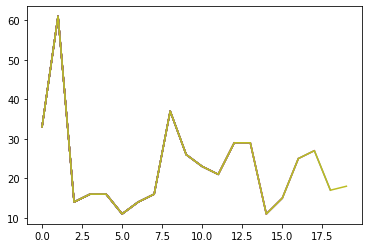

In [11]:
import gym
import numpy as np
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import Adam
import tensorflow as tf
import matplotlib.pyplot as plt

# Buffer 
from tf_agents.replay_buffers import tf_uniform_replay_buffer

class A2C:
    def __init__(self, environment, state_size, action_size, buffer, discount_factor = 0.99, actor_learning_rate = 0.001, critic_learning_rate= 0.005, value_size = 1, actor_entropy = 0.001):
        self.env = environment
        self.state_size = state_size
        self.action_size = action_size

        self.discount_factor = discount_factor
        self.actor_learning_rate = actor_learning_rate
        self.critic_learning_rate = critic_learning_rate
        self.value_size = value_size
        self.actor_entropy = actor_entropy

        self.actor = Actor(self.state_size, self.action_size, self.actor_learning_rate)
        self.actor_network = self.actor.create_actor_network()
        self.critic = Critic(self.state_size, self.value_size, self.critic_learning_rate)
        self.critic_network = self.critic.create_critic_network()

        self.buffer = buffer
        # Save sizes of the stupid tensors
        self.data_spec = self.buffer.obtain_buffer_specs()

    def training_loop(self, number_of_episodes):
        scores, episodes = [], []
        for e in range(number_of_episodes):
            done = False
            score = 0
            state = self.env.reset()
            state = np.reshape(state,[1,self.state_size])
            while not done:
                # Check if we want to render
                #if self.agent.render:
                #    env.render()
                #get action:
                policy = self.actor_network.predict(state,batch_size=1,verbose = 0).flatten()
                action = np.random.choice(self.action_size, 1, p=policy)[0]
                next_state, reward, done, info = self.env.step(action)
                next_state = np.reshape(next_state,[1,self.state_size])

                # Give immediate penalty for an action that terminates the episode immediately, Since we want to maximize the time
                # Note that the max for the cartpole is 499 and it will reset, otherwise we keep the current score if it is not yet done, and if it ended we give a -100 reward
                reward = reward if not done or score == 499 else -100
                
                self.buffer.add((
                    tf.cast(tf.constant(state, shape=self.data_spec[0].shape.as_list()), tf.float32),
                    tf.cast(tf.constant(next_state, shape=self.data_spec[1].shape.as_list()), tf.float32),
                    tf.cast(tf.constant(action, shape=self.data_spec[2].shape.as_list()), tf.float32),
                    tf.cast(tf.constant(reward, shape=self.data_spec[3].shape.as_list()), tf.float32),
                    tf.cast(tf.constant(done, shape=self.data_spec[4].shape.as_list()), tf.float32)
                ))

                score += reward
                state = next_state

                if done:
                    score = score if score == 500.0 else score +100
                    scores.append(score)
                    episodes.append(e)
                    plt.plot(episodes,scores)
                    
                    #if np.mean(scores[-min(10, len(scores)):]) > 490:
                    #    sys.exit()
            if e % 100 ==0: #%50
                #agent.actor.save_weights("./save_model/cartpole_actor.h5")
                #agent.critic.save_weights("./save_model/cartpole_critic.h5")
                
                print("episode: {} score: {}".format(e,np.mean(scores[-10:])))

            #if e % 1000 == 0:
                plt.show()
    
    def train_model(self, state, action, reward, next_state, done):

        optimizer_actor = tf.keras.optimizers.Adam(learning_rate = self.actor_learning_rate)
        optimizer_critic = tf.keras.optimizers.Adam(learning_rate = self.critic_learning_rate)

        # first_layer_weights = self.actor_network.layers[0].get_weights()[0]
        # first_layer_biases  = self.actor_network.layers[0].get_weights()[1]
        # second_layer_weights =self.actor_network.layers[1].get_weights()[0]
        # second_layer_biases  = self.actor_network.layers[1].get_weights()[1]
       
        with tf.GradientTape() as tape_1, tf.GradientTape() as tape_2:
            value = self.critic_network(state)[0] # Get value for this state
            next_value = self.critic_network(next_state)[0] # Get value for the next state

            logits = self.actor_network(state)
            
            # update the advantages and value tables if done
            advantage = reward + (1.0 - done) * self.discount_factor*(next_value) - value # If not yet done, then simply update for the current step.
            #target = reward + (1.0 - done) * self.discount_factor*next_value
            

            #mse = tf.keras.losses.MeanSquaredError()
            #critic_loss = mse(target[0][0], value)
            critic_loss = tf.math.reduce_mean(advantage**2)
            
            action = tf.cast([action], tf.int32)
            sparse_categorical = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
            actor_loss = sparse_categorical(action, logits, sample_weight=advantage) 

            
            
            #entropy_loss = tf.keras.losses.categorical_crossentropy(logits, logits, from_logits=False)
            actor_loss = tf.math.reduce_mean(actor_loss) #- self.actor_entropy * entropy_loss

        actor_gradient = tape_1.gradient(actor_loss, self.actor_network.trainable_variables)
        critic_gradient = tape_2.gradient(critic_loss, self.critic_network.trainable_variables)
    
        print(actor_loss)
        print("huhu")
        print(critic_loss)

       
        optimizer_critic.apply_gradients(zip(critic_gradient, self.critic_network.trainable_variables))

        optimizer_actor.apply_gradients(zip(actor_gradient, self.actor_network.trainable_variables))    
        

# Has to save (Observation, action, reward, terminal state)
from numpy import float32


class Buffer:

    def __init__(
        self,
        batch_size=1,
        buffer_length=800, 
        observation_size=(4,1),
        action_size=1
    ):
        """
        Create replay buffer

        Buffer size = batch_size * buffer_length

        """
        # Save batch size for other functions of buffer
        # NOT the usual batch size in Deep Learning
        # Batches in Uniform Replay Buffer describe size of input added to the buffer
        self.batch_size = batch_size

        # Tell buffer what data & which size to expect
        self.data_spec = (
            tf.TensorSpec(
                shape= observation_size,
                dtype=tf.dtypes.float32,
                name="Observation"
            ),
            tf.TensorSpec(
                shape=observation_size,
                dtype=tf.dtypes.float32,
                name="Next state"
            ),
            tf.TensorSpec(
                shape=[action_size],
                dtype=tf.dtypes.float32,
                name="Action"
            ),
            tf.TensorSpec(
                # Reward size
                shape=[1, ],
                dtype=tf.dtypes.float32,
                name="Reward"
            ),
            tf.TensorSpec(
                shape=[1, ],
                # Either 0 or 1 
                dtype=tf.dtypes.float32,
                name="done"
            )
        )

        # Create the buffer 
        self.buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
            self.data_spec, batch_size, buffer_length
        )

    def obtain_buffer_specs(self):
        return self.data_spec

    def add(self, items):
        """
        length of items must be equal to batch size

        items: list or tuple of batched data from (50, 5)


        """
        # Combine all values from "items" in tensor
        # Not sure wether we need tf.nest.map_structure
        batched_values = tf.nest.map_structure(
            lambda t: tf.stack([t] * self.batch_size),
            items
        )
        
        # Add to batch
        self.buffer.add_batch(batched_values)

    def sample(self, batch_size=50, prefetch_size=70):
        data = self.buffer.as_dataset(single_deterministic_pass=True)

                
        # data = data.map(lambda img, target: (tf.cast(img, tf.float32), target))
        # # normalize inputs from 0/255 to -1/1
        # data = data.map(lambda img, target: ((img/128.)-1, target))
        # # create one-hot vector for targets
        # data = data.map(lambda img, target: (img, tf.one_hot(target, depth=10)))

        # normalize inputs from 0/255 to -1/1
        data = data.map(lambda buffer_content, _: (((buffer_content[0]/128.)-1, (buffer_content[1]/128.)-1, buffer_content[2], buffer_content[3], buffer_content[4]), _))
        data = data.cache()
        data = data.batch(batch_size).prefetch(prefetch_size)
        #later we want these to be sequences (Do we though)
        return data




class Actor:
    def __init__(self, state_size, action_size, learning_rate):
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate

    def create_actor_network(self):
        actor_input = tf.keras.Input(shape=self.state_size) # Define our model
        x = Dense(24, activation='relu', kernel_initializer='he_uniform')(actor_input)
        actor_output = Dense(self.action_size, activation='softmax', kernel_initializer='he_uniform')(x)
        actor_network = tf.keras.Model(actor_input, actor_output, name = "Actor")
        return actor_network

        

class Critic:
    def __init__(self, state_size, value_size, learning_rate):
        self.state_size = state_size
        self.value_size = value_size
        self.learning_rate = learning_rate
    
    def create_critic_network(self):
        critic_input = tf.keras.Input(shape=self.state_size) # Define our model
        x = Dense(24, activation='relu', kernel_initializer='he_uniform')(critic_input)
        critic_output = Dense(self.value_size, activation='linear', kernel_initializer='he_uniform')(x)
        critic_network = tf.keras.Model(critic_input, critic_output, name = "Critic")
        return critic_network



environment = gym.make('CartPole-v1')
#a2c = A2C(environment,state_size,action_size,buffer)
environment.reset()
state_size = environment.observation_space.shape[0]
buffer = Buffer()
# print(environment.action_space) = Discrete(2)
# funktioniert nicht, also hardcoden
#action_size = environment.action_space.shape[0]
action_size = 2
a2c = A2C(environment,state_size,action_size,buffer)
epoch = 3

for e in range(epoch):
    a2c.training_loop(20)
    # Sample from buffer
    data = buffer.sample(batch_size=50, prefetch_size=70)

    
    for sequence in data:
        state, next_state, action, reward, done = sequence[0]
        # We now train the model based on the results of our action taken
        
        a2c.train_model(state,action,reward,next_state,done)


# Maybe needs sequences, gucken as bufffer sample genau returned
# Vanishing gradients
# Learning rate
# gucken warum critic loss so viel riesiger
# tf.stop gradient so das critic den Wert für value optimiert (Wenn gradient für s, s' verwendet wird, kann es sein, das das Netzwerk sich darauf anpasst den loss zwischen beiden zu minimieren)